<a href="https://colab.research.google.com/github/SegusFaultise/CAB420_GROUP_A/blob/master/Copy_of_cab420_at2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
OUTPUT_DIR_S = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/processed_stratified"
TRAIN_DIR_S = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/processed_stratified/train"
VAL_DIR_S = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/processed_stratified/val"
TEST_DIR_S = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/processed_stratified/test"


=== Dataset Statistics ===
Total classes: 845
Total samples: 10767

Samples per split:
train    8613
val      1077
test     1077
dtype: int64


<Figure size 1500x800 with 0 Axes>

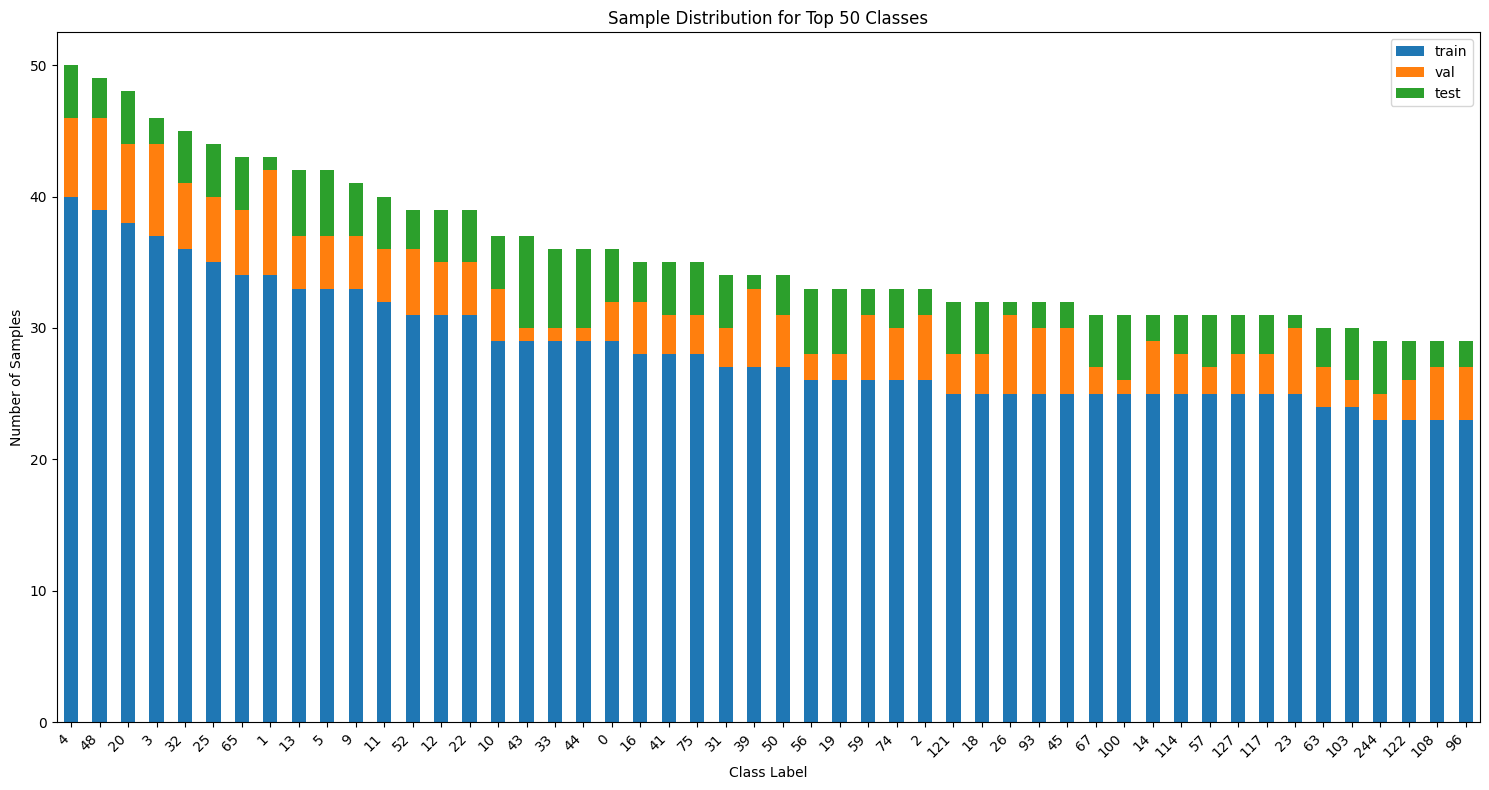

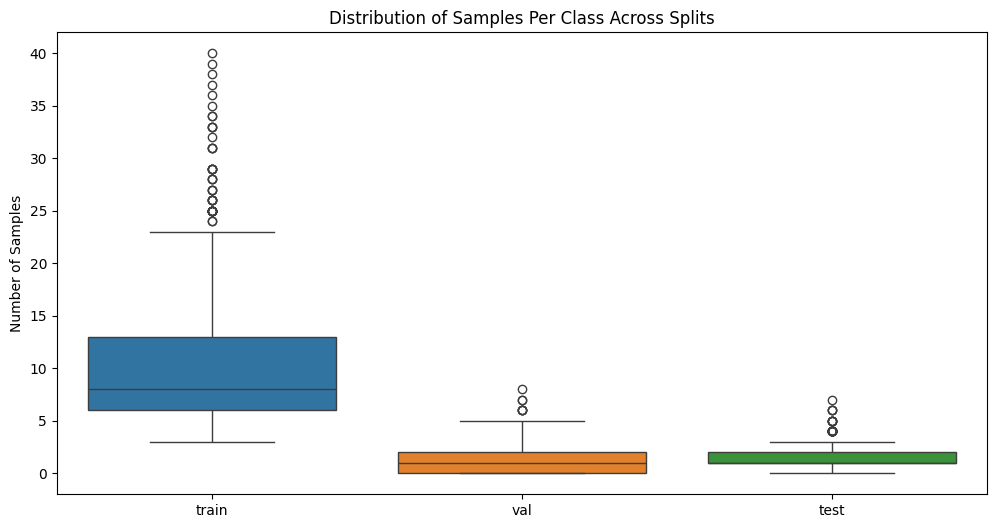

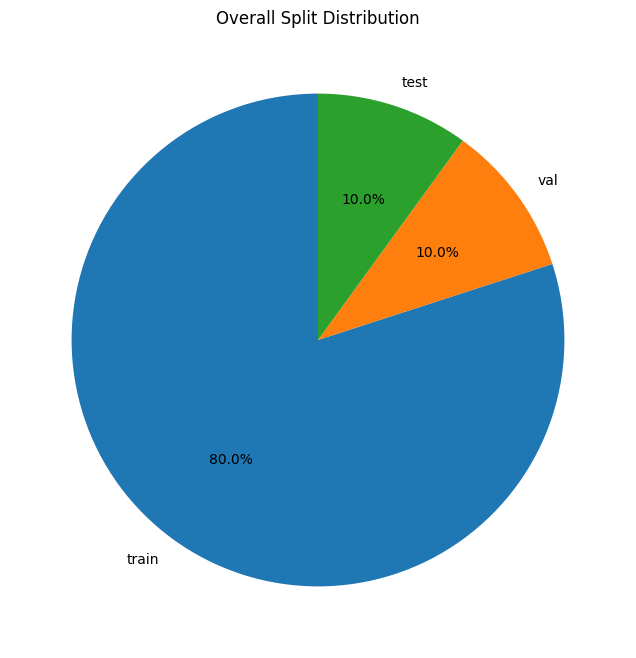

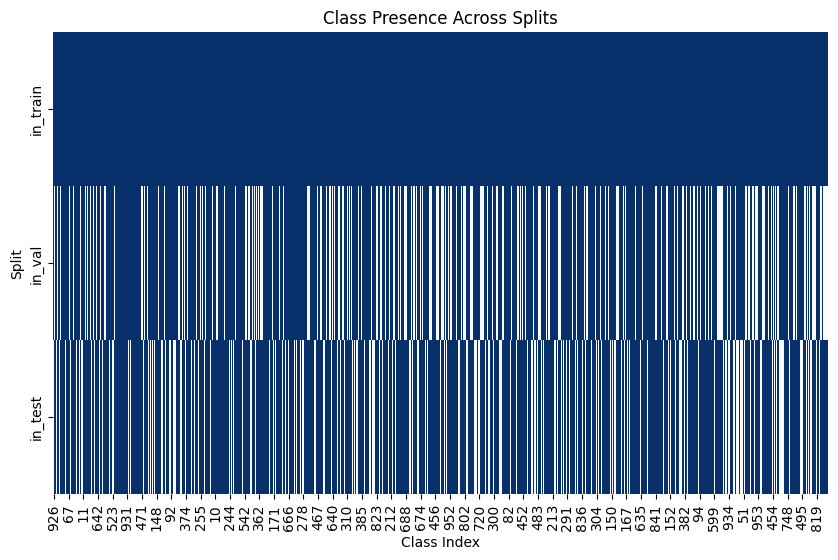


=== Rare Classes (≤5 samples) ===
     train  val  test  total
950      4    0     1      5
469      4    1     0      5
253      4    1     0      5
523      4    1     0      5
581      3    0     1      4
..     ...  ...   ...    ...
814      3    0     1      4
306      4    0     1      5
390      3    0     1      4
463      3    0     1      4
800      4    0     1      5

[121 rows x 4 columns]


<Figure size 1200x600 with 0 Axes>

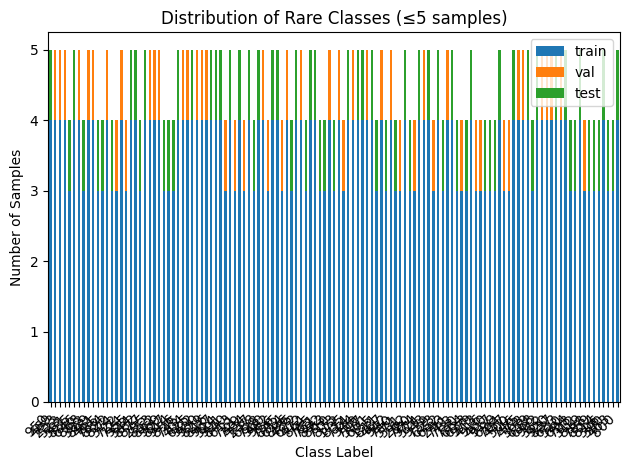


Analysis complete. Visualizations saved to: ./dataset_analysis


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Configuration
DATASET_PATH = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/processed_stratified"
OUTPUT_DIR = "./dataset_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize data storage
class_counts = defaultdict(lambda: defaultdict(int))
total_counts = defaultdict(int)

# Scan directory structure
for split in ['train', 'val', 'test']:
    split_path = os.path.join(DATASET_PATH, split)
    if not os.path.exists(split_path):
        print(f"Warning: {split} directory not found")
        continue

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.mp4', '.avi', '.mkv'))]) # Assuming .pt files are used later based on dataset loader
            class_counts[class_name][split] = count
            total_counts[split] += count

# Convert to DataFrame for analysis
df = pd.DataFrame.from_dict(class_counts, orient='index')
df = df.fillna(0).astype(int)
df['total'] = df.sum(axis=1)

# 1. Basic Statistics
print("\n=== Dataset Statistics ===")
print(f"Total classes: {len(df)}")
print(f"Total samples: {df['total'].sum()}")
print("\nSamples per split:")
print(df[['train', 'val', 'test']].sum())

# 2. Class Distribution Visualization
plt.figure(figsize=(15, 8))

# Samples per class (top N classes for better visualization if num_classes is large)
# Plotting all classes if less than, say, 100, otherwise top 30-50
num_classes_to_plot = min(len(df), 50)
df_sorted = df.sort_values('total', ascending=False)
df_sorted.head(num_classes_to_plot)[['train', 'val', 'test']].plot(kind='bar', stacked=True, figsize=(15,8)) # Use provided figsize
plt.title(f'Sample Distribution for Top {num_classes_to_plot} Classes')
plt.ylabel('Number of Samples')
plt.xlabel('Class Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'top_classes_distribution.png'))
plt.show()

# 3. Class Balance Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['train', 'val', 'test']])
plt.title('Distribution of Samples Per Class Across Splits')
plt.ylabel('Number of Samples')
plt.savefig(os.path.join(OUTPUT_DIR, 'class_balance_boxplot.png'))
plt.show()

# 4. Split Ratios Visualization
split_totals = df[['train', 'val', 'test']].sum()
plt.figure(figsize=(8, 8))
plt.pie(split_totals, labels=split_totals.index, autopct='%1.1f%%', startangle=90)
plt.title('Overall Split Distribution')
plt.savefig(os.path.join(OUTPUT_DIR, 'split_distribution_pie.png'))
plt.show()

# 5. Class Coverage Analysis
coverage = pd.DataFrame({
    'in_train': df['train'] > 0,
    'in_val': df['val'] > 0,
    'in_test': df['test'] > 0
})

plt.figure(figsize=(10, 6))
sns.heatmap(coverage.T, cmap='Blues', cbar=False)
plt.title('Class Presence Across Splits')
plt.xlabel('Class Index') # This will be a numerical index if class names are too many
plt.ylabel('Split')
plt.savefig(os.path.join(OUTPUT_DIR, 'class_coverage_heatmap.png'))
plt.show()

# 6. Rare Classes Analysis
rare_classes_threshold = 5 # Define a threshold for rare classes
rare_classes = df[df['total'] <= rare_classes_threshold]
if not rare_classes.empty:
    print(f"\n=== Rare Classes (≤{rare_classes_threshold} samples) ===")
    print(rare_classes)

    plt.figure(figsize=(12, 6))
    rare_classes[['train', 'val', 'test']].plot(kind='bar', stacked=True)
    plt.title(f'Distribution of Rare Classes (≤{rare_classes_threshold} samples)')
    plt.ylabel('Number of Samples')
    plt.xlabel('Class Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rare_classes_distribution.png'))
    plt.show()
else:
    print(f"\nNo classes found with ≤{rare_classes_threshold} samples.")

# 7. Save full report
with open(os.path.join(OUTPUT_DIR, 'dataset_report.txt'), 'w') as f:
    f.write("=== Dataset Analysis Report ===\n\n")
    f.write(f"Total classes: {len(df)}\n")
    f.write(f"Total samples: {df['total'].sum()}\n\n")
    f.write("Samples per split:\n")
    f.write(str(df[['train', 'val', 'test']].sum()) + "\n\n")
    f.write("Class distribution statistics:\n")
    f.write(str(df.describe()) + "\n\n")
    if not rare_classes.empty:
        f.write(f"Rare classes (≤{rare_classes_threshold} samples): {len(rare_classes)}\n")
        f.write(str(rare_classes) + "\n")
    else:
        f.write(f"No classes found with ≤{rare_classes_threshold} samples.\n")


print("\nAnalysis complete. Visualizations saved to:", OUTPUT_DIR)

In [ ]:
import torch
import torch.nn as nn

class X3D_LSTM(nn.Module):
    def __init__(self, num_classes=1000, lstm_hidden=512, num_layers=1, dropout_prob=0.5):
        super().__init__()

        # 1. Load the X3D model from PyTorch Hub
        print("Loading X3D model from PyTorch Hub...")
        x3d_model_container = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_l', pretrained=True, force_reload=False)
        print("Model loaded.")

        # 2. Define the backbone feature dimension
        # Based on the model printout, x3d_model_container.blocks[4] (s5 stage) outputs 192 channels.
        x3d_backbone_output_dim = 192  # CORRECTED from 2048

        # 3. Construct the X3D feature extractor
        print(f"Constructing X3D feature extractor. Expecting {x3d_backbone_output_dim} output channels from backbone.")
        if hasattr(x3d_model_container, 'blocks') and \
           isinstance(x3d_model_container.blocks, nn.ModuleList) and \
           len(x3d_model_container.blocks) >= 5:

            self.x3d_feature_extractor = nn.Sequential(
                x3d_model_container.blocks[0],  # Stem (s1 equivalent)
                x3d_model_container.blocks[1],  # ResStage (s2 equivalent)
                x3d_model_container.blocks[2],  # ResStage (s3 equivalent)
                x3d_model_container.blocks[3],  # ResStage (s4 equivalent)
                x3d_model_container.blocks[4]   # ResStage (s5 equivalent) - outputs 192 channels
            )
            print("X3D feature extractor constructed successfully.")
        else:
            error_msg = ("ERROR: The expected structure `x3d_model_container.blocks[0-4]` was not found.")
            print(error_msg)
            raise ValueError(error_msg)

        # 4. Define LSTM and Classifier
        self.lstm = nn.LSTM(
            input_size=x3d_backbone_output_dim, # Now correctly set to 192
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(lstm_hidden * 2, num_classes) # *2 for bidirectional
        print("X3D_LSTM initialized successfully.")

    def forward(self, x):
        # Input: x shape [B, C, T, H, W]
        feats = self.x3d_feature_extractor(x)
        # Expected output from backbone (blocks[4]): [B, 192, T_feat, H_feat, W_feat]

        if feats.ndim == 5:
            feats = torch.mean(feats, dim=[3, 4]) # Spatial pooling -> [B, 192, T_feat]

        # Actual size of feats after mean: (Batch, 192, Temporal)
        # Permute for LSTM: (Batch, Temporal, 192)
        feats = feats.permute(0, 2, 1)

        lstm_out, _ = self.lstm(feats)
        out = lstm_out[:, -1, :]

        out = self.dropout(out)
        out = self.classifier(out)
        return out

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob

class MSASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = {} # For mapping string labels to integers if needed
        current_label_idx = 0
        for label_dir_name in sorted(os.listdir(root_dir)): # Sort for consistent label mapping
            label_path = os.path.join(root_dir, label_dir_name)
            if not os.path.isdir(label_path):
                continue

            # Map string label to integer
            if label_dir_name not in self.label_map:
                self.label_map[label_dir_name] = current_label_idx
                current_label_idx +=1

            label_idx = self.label_map[label_dir_name]

            pt_files = glob(os.path.join(label_path, '*.pt'))
            for pt_file in pt_files:
                self.samples.append((pt_file, label_idx)) # Use integer label

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        pt_file, label = self.samples[idx]
        clip = torch.load(pt_file)  # Expected shape: [C, T, H, W]
        if clip.ndim != 4:
            # Attempt to fix common dimension issues, e.g. missing batch or channel
            if clip.ndim == 3: # Potentially (T, H, W) -> add C=3 assuming RGB
                 # This is a guess, be careful. Data should be consistently (C,T,H,W)
                if clip.shape[0] == 3 or clip.shape[-1] == 3: # Check if channel dim exists
                     pass # Needs more specific handling if not C,T,H,W
                # print(f"Warning: Clip tensor shape was 3D {clip.shape}, attempting to unsqueeze C dim. File: {pt_file}")
                # clip = clip.unsqueeze(0) # Example: (T,H,W) -> (1,T,H,W) if grayscale and C is first
                                         # Or ensure data has correct C,T,H,W

            # Basic check, stronger validation might be needed based on data source
            if clip.shape[0] != 3 and clip.shape[1] !=3 : # Assuming C=3 for RGB
                 raise ValueError(f"Clip tensor channel dimension seems incorrect {clip.shape} in file {pt_file}")
            if clip.shape[0] !=3 and clip.shape[1] == 3: # If T,C,H,W -> C,T,H,W
                 clip = clip.permute(1,0,2,3)


            if clip.ndim != 4 or clip.shape[0] != 3 : # Final check for C,T,H,W with C=3
                 raise ValueError(f"Clip tensor shape expected to be 4D (3,T,H,W) but got {clip.shape} in file {pt_file}")


        if self.transform:
            clip = self.transform(clip)
        return clip, label

class NormalizeTransform:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean, dtype=torch.float32)
        self.std = torch.tensor(std, dtype=torch.float32)

    def __call__(self, tensor):
        # tensor shape is expected to be [C, T, H, W]
        # Normalize by (tensor - mean) / std
        # Unsqueeze mean and std to make them [C, 1, 1, 1] for broadcasting
        return (tensor - self.mean[:, None, None, None]) / self.std[:, None, None, None]


def get_dataloaders(train_dir, val_dir, batch_size=8, num_workers=4, transform=None):
    # Using standard ImageNet mean/std, common for X3D. Adjust if your dataset differs.
    norm_mean = [0.45, 0.45, 0.45] # PyTorchVideo X3D uses this mean for normalization
    norm_std = [0.225, 0.225, 0.225] # PyTorchVideo X3D uses this std

    # If a custom transform is passed, use it. Otherwise, use default NormalizeTransform.
    if transform is None:
        transform_to_use = NormalizeTransform(norm_mean, norm_std)
    else:
        transform_to_use = transform # Allows passing torchvision.transforms.Compose([...])

    train_dataset = MSASLDataset(train_dir, transform=transform_to_use)
    val_dataset = MSASLDataset(val_dir, transform=transform_to_use)

    # Store num_classes for model instantiation
    # This assumes class directories are '0', '1', ... 'N-1' or can be mapped to this.
    # Or, use len(train_dataset.label_map) if label_map is populated correctly
    num_classes_in_dataset = len(train_dataset.label_map) if hasattr(train_dataset, 'label_map') and train_dataset.label_map else 0
    if num_classes_in_dataset == 0: # Fallback if label_map not used or empty
        try:
            num_classes_in_dataset = len(next(os.walk(train_dir))[1]) # Number of subdirectories
        except StopIteration:
            num_classes_in_dataset = 0 # No subdirectories
    print(f"Detected {num_classes_in_dataset} classes in training directory.")


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)

    return train_loader, val_loader, num_classes_in_dataset

In [ ]:
# Hyperparameters from the script
learning_rate = 1e-4
batch_size = 32  # adjust based on your GPU memory
num_epochs = 20
num_workers = 8 # psutil.cpu_count(logical=False) or True can be used here
weight_decay = 1e-5
lstm_hidden = 512
dropout_prob = 0.5
num_layers = 1 # For LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.cuda.amp import GradScaler, autocast # Old import paths
from torch.amp import GradScaler # Updated import path for GradScaler
from torch.amp import autocast as torch_autocast # Updated import path for autocast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm


def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device, epoch_idx, total_epochs): # Added epoch_idx, total_epochs
    model.train()
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0

    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_idx + 1}/{total_epochs} [Train]", unit="batch", leave=False)

    for clips, labels in progress_bar: # Iterate through tqdm object
        clips = clips.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch_autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = model(clips)
            loss = criterion(outputs, labels)

        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * clips.size(0)
        _, preds = torch.max(outputs, 1)
        correct_samples += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Update tqdm postfix with current batch loss and running epoch metrics
        # Format numbers for readability
        postfix_dict = {
            'loss': f"{loss.item():.4f}", # Current batch loss
            'avg_loss': f"{running_loss / total_samples:.4f}" if total_samples > 0 else "N/A", # Running average epoch loss
            'acc': f"{correct_samples / total_samples:.4f}" if total_samples > 0 else "N/A", # Running epoch accuracy
        }
        if optimizer is not None and len(optimizer.param_groups) > 0: # Check if optimizer and param_groups exist
            postfix_dict['lr'] = f"{optimizer.param_groups[0]['lr']:.1e}"

        progress_bar.set_postfix(postfix_dict)

    # The old print statement for batch progress (if (i + 1) % 100 == 0:) is no longer needed.

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_samples / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device, epoch_idx, total_epochs): # Added epoch_idx, total_epochs
    model.eval()
    running_loss = 0.0
    correct_samples = 0
    total_samples = 0
    all_preds_list = []
    all_labels_list = []

    # Wrap the dataloader with tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_idx + 1}/{total_epochs} [Val]", unit="batch", leave=False)

    with torch.no_grad():
        for clips, labels in progress_bar:
            clips = clips.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch_autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = model(clips)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * clips.size(0)
            _, preds = torch.max(outputs, 1)
            correct_samples += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds_list.append(preds.cpu().numpy())
            all_labels_list.append(labels.cpu().numpy())

            # Update tqdm postfix
            progress_bar.set_postfix(
                loss=f"{loss.item():.4f}", # Current batch loss
                avg_loss=f"{running_loss / total_samples:.4f}" if total_samples > 0 else "N/A", # Running average epoch loss
                acc=f"{correct_samples / total_samples:.4f}" if total_samples > 0 else "N/A" # Running epoch accuracy
            )

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_samples / total_samples if total_samples > 0 else 0

    if not all_preds_list:
        return epoch_loss, epoch_acc, np.array([]), np.array([])

    all_preds = np.concatenate(all_preds_list)
    all_labels = np.concatenate(all_labels_list)

    return epoch_loss, epoch_acc, all_preds, all_labels


def train_model_with_metrics(model, train_loader, val_loader, device, num_epochs, learning_rate, weight_decay, num_classes_from_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler(enabled=(device.type == 'cuda'))

    best_val_acc = 0.0
    best_epoch = -1
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_preds = np.array([])
    best_val_labels = np.array([])

    for epoch in range(num_epochs): # epoch is 0-indexed (epoch_idx)
        # This print can stay, as tqdm bars will appear below it for train and val phases
        print(f"\nStarting Epoch [{epoch+1}/{num_epochs}]")

        # Pass current epoch index and total_epochs
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch, num_epochs)
        val_loss, val_acc, current_epoch_val_preds, current_epoch_val_labels = validate_one_epoch(model, val_loader, criterion, device, epoch, num_epochs)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # This summary print is good to keep after the progress bars are done for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Summary: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_val_preds = current_epoch_val_preds
            best_val_labels = current_epoch_val_labels
            try:
                torch.save(model.state_dict(), "best_model.pth")
                print(f"Saved best model (Epoch {best_epoch} with Val Acc: {best_val_acc:.4f}).")
            except Exception as e:
                print(f"Error saving model: {e}")

    print(f"\nTraining complete. Best Val Acc: {best_val_acc:.4f} at Epoch {best_epoch}")
    return train_losses, val_losses, train_accs, val_accs, best_val_preds, best_val_labels


def plot_train_val_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 6)) # Adjusted figure size

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss') # Added markers
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss') # Added markers
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Train Accuracy') # Added markers
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy') # Added markers
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout
    plt.savefig(os.path.join(OUTPUT_DIR, "training_curves.png")) # Save the plot
    plt.show()


def plot_confusion_matrix_func(y_true, y_pred, class_names): # Renamed to avoid conflict
    if len(y_true) == 0 or len(y_pred) == 0:
        print("Cannot plot confusion matrix: No true or predicted labels available.")
        return

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names))) # Ensure all classes are considered
    plt.figure(figsize=(max(10, int(len(class_names)*0.5)), max(8, int(len(class_names)*0.4)))) # Dynamic figsize

    # Display only a subset of class names if too many, for readability
    tick_interval = 1
    if len(class_names) > 20 : # Only show every Nth label if too many classes
        tick_interval = int(len(class_names)/20)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names[::tick_interval],
                yticklabels=class_names[::tick_interval])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Best Validation Epoch)')
    plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png")) # Save the plot
    plt.show()


def plot_per_class_accuracy(y_true, y_pred, class_names):
    if len(y_true) == 0 or len(y_pred) == 0:
        print("Cannot plot per-class accuracy: No true or predicted labels available.")
        return

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    # Calculate per-class accuracy, handle division by zero for classes not in y_true
    class_counts_true = cm.sum(axis=1)
    class_acc = np.zeros(len(class_names))

    # cm.diagonal() gives true positives for each class
    # class_counts_true gives total instances of each class in y_true
    for i in range(len(class_names)):
        if class_counts_true[i] > 0:
            class_acc[i] = cm.diagonal()[i] / class_counts_true[i]
        else:
            class_acc[i] = 0 # Or np.nan if preferred for classes with no true samples

    plt.figure(figsize=(max(12, int(len(class_names)*0.3)), 7)) # Dynamic figsize
    sns.barplot(x=np.arange(len(class_names)), y=class_acc) # Use numerical index for x for consistent plotting

    tick_interval = 1
    if len(class_names) > 30:
        tick_interval = int(len(class_names)/30)

    plt.xticks(ticks=np.arange(len(class_names))[::tick_interval], labels=class_names[::tick_interval], rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy (Best Validation Epoch)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "per_class_accuracy.png")) # Save the plot
    plt.show()

In [ ]:
!pip install torchviz
!pip install fvcore

In [ ]:
if __name__ == '__main__': # Encapsulate script logic
    # Ensure fvcore is installed (usually for other tools, not directly used here but was in original script)
    # os.system("pip install fvcore -q") # -q for quiet

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Get Dataloaders and actual number of classes from the dataset
    # Assuming TRAIN_DIR_S and VAL_DIR_S are defined
    # The get_dataloaders function was updated to return num_classes
    train_loader, val_loader, num_classes = get_dataloaders(
        TRAIN_DIR_S,
        VAL_DIR_S,
        batch_size=batch_size,
        num_workers=num_workers, # Make sure this is appropriate for your system
        transform=None  # Default normalization will be applied
    )

    if num_classes == 0:
        raise ValueError("Number of classes detected is 0. Check dataset paths and structure.")

    print(f"Model will be trained for {num_classes} classes.")

    # Initialize model with the detected number of classes
    model = X3D_LSTM(
        num_classes=num_classes, # Use detected num_classes
        lstm_hidden=lstm_hidden,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    # Start training
    train_losses, val_losses, train_accs, val_accs, best_val_preds, best_val_labels = train_model_with_metrics(
        model, train_loader, val_loader, device, num_epochs, learning_rate, weight_decay, num_classes
    )

    # Plotting results
    plot_train_val_curves(train_losses, val_losses, train_accs, val_accs)

    # Assuming class names can be derived from label_map or directory names
    # For plotting confusion matrix and per-class accuracy, we need class names
    # Re-create dataset instance just to get label_map if needed, or pass it from get_dataloaders
    # This is a bit inefficient, better to get label_map from get_dataloaders if possible
    temp_train_dataset = MSASLDataset(TRAIN_DIR_S) # To get label_map
    # Sort label_map by value (class index) to get ordered class names
    class_names = [name for name, index in sorted(temp_train_dataset.label_map.items(), key=lambda item: item[1])]

    if len(best_val_preds) > 0 and len(best_val_labels) > 0:
        plot_confusion_matrix_func(best_val_labels, best_val_preds, class_names)
        plot_per_class_accuracy(best_val_labels, best_val_preds, class_names)
    else:
        print("Skipping confusion matrix and per-class accuracy plots due to no validation predictions.")

Using device: cuda
Detected 845 classes in training directory.
Model will be trained for 845 classes.
Loading X3D model from PyTorch Hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


Model loaded.
Constructing X3D feature extractor. Expecting 192 output channels from backbone.
X3D feature extractor constructed successfully.
X3D_LSTM initialized successfully.

Starting Epoch [1/20]


Epoch 1/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

Epoch 1/20 [Val]:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch [1/20] Summary: Train Loss: 6.6791, Train Acc: 0.0035 | Val Loss: 6.7092, Val Acc: 0.0009
Saved best model (Epoch 1 with Val Acc: 0.0009).

Starting Epoch [2/20]


Epoch 2/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

Epoch 2/20 [Val]:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch [2/20] Summary: Train Loss: 6.4319, Train Acc: 0.0086 | Val Loss: 6.7694, Val Acc: 0.0046
Saved best model (Epoch 2 with Val Acc: 0.0046).

Starting Epoch [3/20]


Epoch 3/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

Epoch 3/20 [Val]:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch [3/20] Summary: Train Loss: 5.9833, Train Acc: 0.0332 | Val Loss: 6.8438, Val Acc: 0.0046

Starting Epoch [4/20]


Epoch 4/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c80ebfd6a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c80ebfd6a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/20 [Val]:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch [4/20] Summary: Train Loss: 5.3445, Train Acc: 0.0949 | Val Loss: 7.0086, Val Acc: 0.0074
Saved best model (Epoch 4 with Val Acc: 0.0074).

Starting Epoch [5/20]


Epoch 5/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

Epoch 5/20 [Val]:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch [5/20] Summary: Train Loss: 4.6892, Train Acc: 0.1811 | Val Loss: 7.1605, Val Acc: 0.0065

Starting Epoch [6/20]


Epoch 6/20 [Train]:   0%|          | 0/269 [00:00<?, ?batch/s]

In [ ]:
# torchviz visualization (optional, can be run separately)
    # Ensure torchviz is installed: os.system("pip install torchviz -q")
    try:
        from torchviz import make_dot
        print("\nGenerating model graph with torchviz...")
        # Create a dummy input tensor with expected input shape: [B, C, T, H, W]
        # Adjust T, H, W as per your dataset's typical preprocessed clip dimensions
        dummy_batch_size = 1
        dummy_channels = 3
        dummy_frames = 16  # Example: X3D-L often uses 16 frames
        dummy_height = 224 # Example: X3D-L common input height
        dummy_width = 224  # Example: X3D-L common input width

        # Re-initialize model on CPU for visualization to avoid CUDA issues if any
        viz_model = X3D_LSTM(num_classes=num_classes, lstm_hidden=lstm_hidden, num_layers=num_layers, dropout_prob=dropout_prob).to('cpu')
        viz_model.eval()

        dummy_input = torch.randn(dummy_batch_size, dummy_channels, dummy_frames, dummy_height, dummy_width, device='cpu')

        # Forward pass to get output and generate graph
        with torch.no_grad():
            output = viz_model(dummy_input)

        dot = make_dot(output, params=dict(viz_model.named_parameters()), show_attrs=False, show_saved=False)
        graph_filename = 'x3d_lstm_model_graph'
        dot.render(graph_filename, format='png') # Save as PNG
        print(f"Model graph saved as {graph_filename}.png")

    except ImportError:
        print("torchviz not installed. Skipping model graph generation.")
    except Exception as e:
        print(f"Could not generate model graph: {e}")


    # CPU info (already present in user script)
    try:
        import psutil
        print("\nCPU Information:")
        print(f"  Physical cores: {psutil.cpu_count(logical=False)}")
        print(f"  Logical cores: {psutil.cpu_count(logical=True)}")
    except ImportError:
        print("psutil not installed. Skipping CPU information.")

In [ ]:
 # Video corruption scan (already present in user script)
    # Note: This part was scanning OUTPUT_DIR which contains analysis results, not video files.
    # It should target the actual video dataset path if used for cleaning raw videos.
    # For this script, assuming .pt files are used, this ffmpeg scan might not be relevant for them.
    # If you have raw videos in DATASET_PATH or its subdirs (like MS-ASL-Clips/raw_videos), scan there.
    # The current code uses *.pt files in processed_stratified, so this scan on OUTPUT_DIR is likely not useful.
    # import subprocess
    # from concurrent.futures import ThreadPoolExecutor, as_completed

    # def is_video_corrupt(filepath):
    #     # ... (definition from user script) ...
    # def scan_video_file(filepath):
    #     # ... (definition from user script) ...
    # def scan_videos_multithreaded(folder_path, extensions=['.mp4', '.avi', '.mkv'], max_workers=8):
    #     # ... (definition from user script) ...

    # print("\nSkipping video corruption scan as it's configured for OUTPUT_DIR and this script uses .pt files.")
    # # Example if you wanted to scan a raw video folder:
    # # raw_video_folder = "/content/drive/MyDrive/Datasets/MS-ASL-Clips/raw_videos" # Example path
    # # if os.path.exists(raw_video_folder):
    # #     print(f"Scanning for corrupt videos in {raw_video_folder}...")
    # #     bad_videos = scan_videos_multithreaded(raw_video_folder, max_workers=max(1, psutil.cpu_count(logical=False) // 2))
    # #     print(f"Found and (attempted to) delete {len(bad_videos)} corrupted videos.")
    # # else:
    # #     print(f"Raw video folder {raw_video_folder} not found, skipping scan.")